In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from matplotlib import pyplot as plt

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


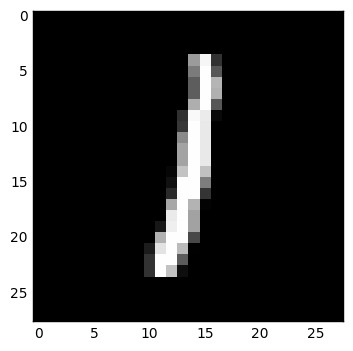

In [2]:
imageSize = 28
viewImageIndex = 4

random_image = np.reshape(trX[viewImageIndex],(imageSize,imageSize))

plt.imshow(random_image, cmap='gray', interpolation='nearest');
print trY[viewImageIndex]

output will be 24
output will be 8
took 3 secs to get all filters
total inputFilters 576
took 4 secs to compute 0 filter
took 4 secs to compute 1 filter
took 4 secs to compute 2 filter
took 0 secs to get all filters
total inputFilters 64
took 0 secs to compute 0 filter
took 0 secs to compute 1 filter
took 0 secs to compute 2 filter
123123
asdfqwer1
asdfqwer2
running
0.900006426573
0.900000703096
0.899995369911
0.899989893436
0.899983739138
0.8999762609
0.899966805458
0.899954504013
0.899938243389
0.899916572809
0.89988769865
0.899849273682
0.899798400164
0.899731750011
0.899645463943
0.898178170919
0.897992873907
0.897834517479
0.897700048447
0.89758052206
0.897462118387
0.897327789068
0.897154291391


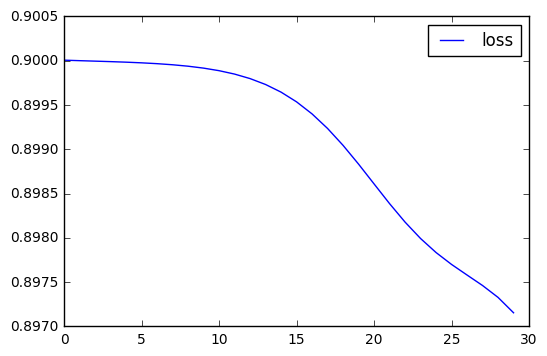

In [ ]:
import math
tf.reset_default_graph()
import time

numInputs = 28 ** 2
numOutputs = 10
learningRate = 0.01
epoch = 30
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

class convLayer():
    def __init__(self,numFilters,filterSize,stride,inputSize,numInputs):
        self.filters = []
        self.stride = stride
        self.inputSize = inputSize
        self.filterSize = filterSize
        self.numFilters = numFilters
        self.outputSize = ((inputSize - filterSize)/stride+1)
        self.numInputs = numInputs
        
        self.bias = init_weights((1,1))
    
        if not int(self.outputSize) == round(self.outputSize):
            print "outputSize is not a int!"
        
        print "output will be %d" % self.outputSize
    
        for n in range(numFilters):
            filterMat = init_weights((numInputs,filterSize,filterSize))
            self.filters.append(filterMat)
    
    def getAllInputFilters(self,inputMatrix):
        inputFilters = []

        horizontalOffset = int(math.floor(self.filterSize / 2))
        
        startTime = time.time()
        for verticalPass in range(self.outputSize):
            verticalPass2 = verticalPass * self.stride
            
            for horizontalPass in range(self.outputSize):
                horizontalPass2 = horizontalPass * self.stride
                midPoint = horizontalPass2 + horizontalOffset
                
                inputFilter = []
                for numInput in range(self.numInputs):
                    filterInputElem = inputMatrix[numInput, midPoint-horizontalOffset : midPoint+horizontalOffset+1,verticalPass2 : verticalPass2+self.filterSize]
                    inputFilter.append(filterInputElem)

                inputFilters.append(tf.pack(inputFilter))
            
        self.lenFilter = len(inputFilters)
        
        print "took %d secs to get all filters" % (time.time() - startTime)
        return tf.pack(inputFilters)
    
    def forwardProp(self,inputFilters):
        
        outputMats = []
        
        print("total inputFilters %d" % self.lenFilter)
        
        for nn,filterMap in enumerate(self.filters):
            startTime = time.time()
            outputArr = []
            for n in range(self.lenFilter):
                out = tf.add(tf.reduce_sum(tf.mul(inputFilters[n],filterMap)),self.bias)
                outputArr.append(out)
            outputMats.append(outputArr)
            print "took %d secs to compute %d filter" % ((time.time() - startTime) , nn)
        
        return tf.reshape(outputMats,[self.numFilters,self.outputSize,self.outputSize])

class maxPoolingLayer():
    def __init__(self,numFilters,filterSize,inputSize):
        self.filterSize = filterSize
        self.inputSize = inputSize
        self.numFilters = numFilters
        self.filterPasses = inputSize / filterSize
        self.outputSize = inputSize / filterSize
    
    def getMaxPool(self,inputTensor):
        outputTensors = []
        
        for filterIndex in range(self.numFilters):
            outputTensor = []
            for h in range(self.filterPasses):
                for v in range(self.filterPasses):
                    outputTensor.append(tf.nn.relu(tf.reduce_max(inputTensor[filterIndex,h * self.filterSize : (h+1) * self.filterSize , v * self.filterSize : (v+1) * self.filterSize ])))
            
            outputTensors.append(tf.reshape(outputTensor,[self.filterPasses,self.filterPasses]))
        return tf.pack(outputTensors)
        
        
X = tf.placeholder("float", [imageSize ** 2])
Y = tf.placeholder("float", [1,numOutputs])

numFilters = 3

convLayer_1 = convLayer(numFilters,5,1,imageSize,1)
poolLayer_1 = maxPoolingLayer(numFilters,2,convLayer_1.outputSize)

convLayer_2 = convLayer(numFilters,5,1,poolLayer_1.outputSize,numFilters)
poolLayer_2 = maxPoolingLayer(numFilters,2,convLayer_2.outputSize)

feedNetBias = init_weights((1,1))
feedW = init_weights((numFilters * poolLayer_2.outputSize ** 2,numOutputs))

def Model():
    inputReshape = tf.reshape(X,(1,imageSize,imageSize))
    
    # First Conv Layer
    outputConv_1 = convLayer_1.forwardProp(convLayer_1.getAllInputFilters(inputReshape))
    outputPool_1 = poolLayer_1.getMaxPool(outputConv_1)
    
#     # Second Conv Layer
    outputConv_2 = convLayer_2.forwardProp(convLayer_2.getAllInputFilters(outputPool_1))
    outputPool_2 = poolLayer_2.getMaxPool(outputConv_2)

#     return outputConv_2
    
#     # Feed Net
    outputToFeedNet = tf.reshape(outputPool_2,[1,numFilters * poolLayer_2.outputSize ** 2])
    return tf.nn.softmax(tf.add(tf.matmul(outputToFeedNet,feedW),feedNetBias))

with tf.device('/gpu:0'):
    
    predY = Model()
    print "123123"
    loss = tf.reduce_sum(tf.square(predY-Y))
    print "asdfqwer1"
    opt = tf.train.GradientDescentOptimizer(learningRate).minimize(loss)
    print "asdfqwer2"
    sess.run(tf.initialize_all_variables())
    print("running")

    # outputNet = sess.run(model,feed_dict={X:trX[viewImageIndex]})
    # print outputNet.shape

    losses = []

    for epoch_i in range(epoch):
        for n,t in enumerate(trX[:250]):
            sess.run(opt,feed_dict={X:trX[n],Y:[trY[n]]})

        totalLoss = 0
        totalCount = 0
        for n,t in enumerate(trX[:250]):
            totalLoss += sess.run(loss,feed_dict={X:trX[n],Y:[trY[n]]})
            totalCount += 1
    
        lossVal = totalLoss / totalCount
        losses.append(lossVal)
        print lossVal

    plt.plot(range(epoch),losses, 'b',label='loss')
    plt.legend()
    plt.show()

# outputNet = sess.run(tf.constant([1,2,3,4]))
# print outputNet